# Entropic estimation of optimal transport maps

We experiment with the 

The idea ...

Setting : 2-samples estimates

*copié de la page 9*

The article proposes the following estimator of the map :
$$T_{\varepsilon,(n, n)}(x)=\frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}$$
where $g_{\varepsilon,(n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$, obtained by the ouput of Sinkhorn algo..

In [8]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [9]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.costs import SqPNorm, SqEuclidean
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

In [211]:
def create_points(rng, n, d, T): # T must be a monotone scalar function !
    rngs = jax.random.split(rng, 2)

    x = jax.random.uniform(rngs[0], (n,d), minval = -1, maxval = 1)
    z = jax.random.uniform(rngs[1], (n,d), minval = -1, maxval = 1)

    y = T(z)
    
    return x, y

Create a {class}`~ott.problems.linear.linear_problem.LinearProblem` comparing two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [212]:
def entropic_map_estimator_TWO_sample(ot_sink):
    DualPotentials = ot_sink.to_dual_potentials()
    return DualPotentials.transport

In [221]:
def OT_sinkhorn_solved(rng, T, n, d, alpha, epsilon = None):
    
    x,y = create_points(rng, n, d, T)

    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)
    if epsilon == None : # epsilon optimaly chosen  according to `Pooladian and Niles-Weed, 2021`
        epsilon = n ** (- 1/(d_ + alpha_bar + 1))
        print("Chosen epsilon :", epsilon)

    geom = pointcloud.PointCloud(x, y, cost_fn = SqEuclidean() , epsilon = epsilon)
    ot_prob = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_sink = solver(ot_prob)


    return ot_sink

In [231]:
rng = jax.random.PRNGKey(0)
T = lambda x : 3 * x**2 * jnp.sign(x) # jnp.log(1.2 + x) #
n = 1000
d = 2
alpha = 1

ot_sink = OT_sinkhorn_solved(rng, T, n, d, alpha, epsilon=0.02)


[]

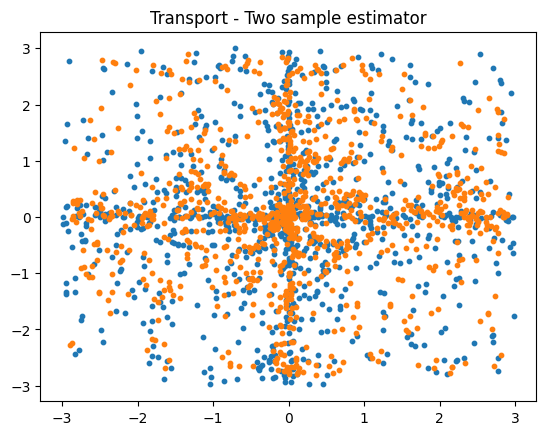

In [232]:
T_hat_2 = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)

rng = jax.random.PRNGKey(1)
x_tilde, _ = create_points(rng, n, d, T)

y_tilde = T(x_tilde)
y_tilde_estimated_2 = T_hat_2(x_tilde)


plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10)
plt.scatter(y_tilde_estimated_2[:,0], y_tilde_estimated_2[:,1], s = 10)
plt.title("Transport - Two sample estimator")
plt.plot()


## Convergence bound


In [234]:
def entropic_map_mse(rng, n_, T_hat, T):
    X_ = jax.random.uniform(rng, (n_,d), minval = -1, maxval = 1)
    return n_**(-1) * jnp.sum((T_hat(X_) - T(X_))**2)

In [265]:
def bound(alpha, d):
    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)

    bound_fn = lambda n: n**(- (alpha_bar+1)/(2*(d_+alpha_bar+1))) * jnp.log(n)
    
    return bound_fn

def minimax_bound(alpha,d):
    bound_fn = lambda n: n**(-2*alpha/(2*alpha -2 +d))
    return bound_fn

In [267]:
rng = jax.random.PRNGKey(2)
rngs = jax.random.split(rng, 2)
N = 10000

n_stacked = [100, 500, 1000, 2000, 5000, 10000]

mse_stacked = []
for k in n_stacked :
    ot_sink = OT_sinkhorn_solved(rngs[0], T, k, d, alpha, epsilon=None)
    T_hat = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)
    mse = entropic_map_mse(rngs[1], N, T_hat, T)

    mse_stacked.append(mse)
    
bound_fn = bound(alpha, d)
bound_minimax_fn = minimax_bound(alpha, d)


minimax_bound_evaluations = [bound_minimax_fn(j) for j in n_stacked]
bound_evaluations = [bound_fn(j).item() for j in n_stacked]

Chosen epsilon : 0.31622776
Chosen epsilon : 0.21147425
Chosen epsilon : 0.17782794
Chosen epsilon : 0.14953488
Chosen epsilon : 0.11892071
Chosen epsilon : 0.1


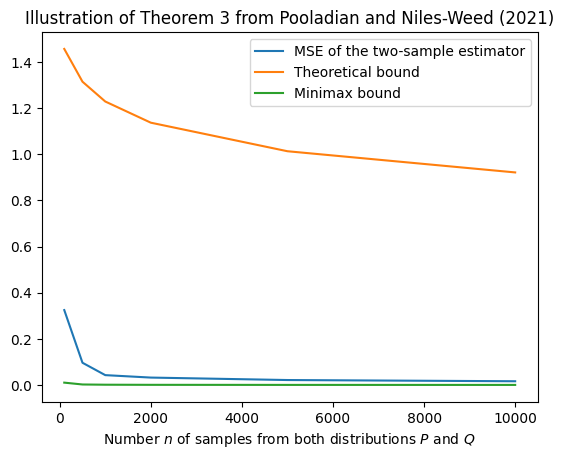

In [269]:
plt.figure()
plt.plot(n_stacked, mse_stacked, label = "MSE of the two-sample estimator")
plt.plot(n_stacked, bound_evaluations , label = "Theoretical bound")
plt.plot(n_stacked, minimax_bound_evaluations , label = "Minimax bound")
plt.legend()
plt.title("Illustration of Theorem 3 from Pooladian and Niles-Weed (2021)")
plt.xlabel("Number $n$ of samples from both distributions $P$ and $Q$")
plt.show()